# Fit double components

In this notebook we will create a syntehtic SN3 spectrum with two Halpha components. We will then fit spectrum and plot the fit.


In [1]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
from LUCI.LuciSim import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from  scipy import interpolate
import LUCI.LuciFit as lfit
import keras

In [2]:
# Create first spectrum
lines = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
fit_function = 'sincgauss'
ampls = [2, 1, 0.3, 0.15, 0.25]  # Just randomly choosing these
velocity = 0  # km/s
broadening = 20  # km/s
filter_ = 'SN3'
resolution = 5000
snr = 50

spectrum_axis, spectrum = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

In [3]:
# Now create the second spectrum and add them together
lines = ['Halpha']
ampls = [1]  # Just randomly chosen
velocity = 200  # km/s

spectrum_axis2, spectrum2 = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

# Add them together
spectrum += spectrum2


In [4]:
# And we can now take a look

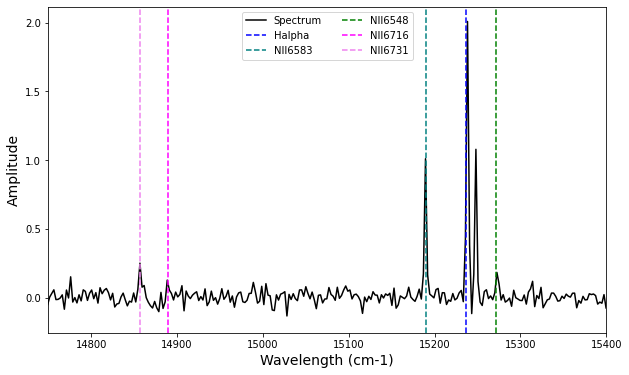

In [5]:
plt.figure(figsize=(10,6))
plt.plot(spectrum_axis, spectrum, color='black', label='Spectrum')
plt.xlim(14750, 15400)
plt.xlabel('Wavelength (cm-1)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.axvline(1e7/656.3, label='Halpha', color='blue', linestyle='--')
plt.axvline(1e7/658.3, label='NII6583', color='teal', linestyle='--')
plt.axvline(1e7/654.8, label='NII6548', color='green', linestyle='--')
plt.axvline(1e7/671.6, label='NII6716', color='magenta', linestyle='--')
plt.axvline(1e7/673.1, label='NII6731', color='violet', linestyle='--')
plt.legend(ncol=2)

plt.show()

We can clearly see that something is up with the Halpha line (because wd threw a second one there of course). Next, we can fit the components.

In [6]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('/home/carterrhea/Documents/LUCI/ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]
f = interpolate.interp1d(spectrum_axis, spectrum, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale

In [7]:
fit = lfit.Fit(spectrum, spectrum_axis, wavenumbers_syn, 'sincgauss', 
               ['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731', 'Halpha'], 
               [1,1,1,1,1,2], [1,1,1,1,1,2],
               #['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               #[1,1,1,1,1], [1,1,1,1,1], 
               keras.models.load_model('/home/carterrhea/Documents/LUCI/ML/R5000-PREDICTOR-I-SN3'),
               bayes_bool=True
                 )
fit_dict = fit.fit()


['Halpha' 'NII6548' 'NII6583' 'SII6716' 'SII6731']
Halpha [0, 5]


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

[0.9633471164699015, 15238.86974662632, 1.2464015883691486, 0.3970621714911101, 15190.75525209685, 1.2414873674258586, 0.13186567685660838, 15273.066026159018, 1.2488781623595608, 0.05981286743598843, 14891.060270050733, 1.2182933295358684, 0.1119809902006786, 14858.096395697958, 1.2143804178845654, 0.5171165017618932, 15248.376396986676, 0.9971229135917306, 0.006716815953197801]
[0.011007492630080655, 9.539514449729657, 0.009670619724449705, 0.011203575579771821, 11.72054480313224, 0.010910104114182473, 0.011513214309811837, 10.7952718969839, 0.010809891005750685, 0.010305347785784286, 9.994431540904204, 0.010659266771603653, 0.011527068156639418, 10.72103713600144, 0.011006918925461157, 0.011597845301795565, 10.516157665729573, 0.010839199864490216, 0.006451214286557226]


In [8]:
fit_dict['velocities']

[-28.960323539910675,
 -20.90864528101751,
 -25.481429282128634,
 -46.07163955630893,
 -22.85263400858604,
 -215.9782537243023]

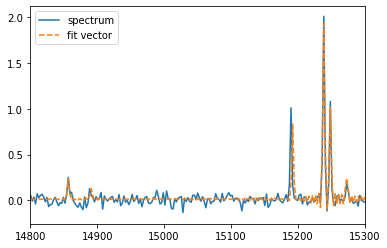

In [9]:
plt.plot(spectrum_axis, spectrum, label='spectrum')
plt.plot(spectrum_axis, fit_dict['fit_vector'], label='fit vector', linestyle='--')
plt.xlim(14800, 15300)
plt.legend()

In [10]:
fit_dict

{'fit_sol': [1.9344070875937887,
  15238.86974662632,
  1.2464015883691486,
  0.7973033454050739,
  15190.75525209685,
  1.2414873674258586,
  0.2647871110638708,
  15273.066026159018,
  1.2488781623595608,
  0.120104615168689,
  14891.060270050733,
  1.2182933295358684,
  0.22485853480699258,
  14858.096395697958,
  1.2143804178845654,
  1.0383731980072477,
  15248.376396986676,
  0.9971229135917306,
  0.013487408810170874],
 'fit_uncertainties': [0.022103114647076108,
  9.539514449729657,
  0.009670619724449705,
  0.02249685044713623,
  11.72054480313224,
  0.010910104114182473,
  0.023118606970556167,
  10.7952718969839,
  0.010809891005750685,
  0.020693203369922492,
  9.994431540904204,
  0.010659266771603653,
  0.02314642558238937,
  10.72103713600144,
  0.011006918925461157,
  0.02328854653639337,
  10.516157665729573,
  0.010839199864490216,
  0.01295407898788526],
 'amplitudes': [1.9344070875937887,
  0.7973033454050739,
  0.2647871110638708,
  0.120104615168689,
  0.224858534